# Road Surface Deterioration Modelling

Modelling was undertaken using the most recent road condition data which assessed the entire road network. This particular notebook focused on modelling asphalt and seal deterioration over time at the portfolio level given that Finance only assigns a single useful life based on material type. Key model inputs were:
- Condition scores for the surface calculated in a separate script which involved map matching from the collected information to our asset register and weighting defects based on relative severity
- Age from Council's asset register taken from the FAR. Anomalies were observed with these values (such as a 62 year old asphalt surface which is highly unlikely). As such the model used condition scores to correct the age anomalies.

From the asphalt deterioation modelling it was observed that on a portfolio level, AC crosses the very poor threshold (immediate intervention required) at around 25 years. These resutls prompted a review/update of Council's current AC useful life from 20 to 25 years.

In [6]:
# %%

""" Import Modules """
import pandas as pd
import geopandas as gpd
import shapely as shp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import contextily as cnx
from pathlib import Path
import os
os.environ['PROJ_NETWORK'] = 'OFF'

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8-talk')
plt.style.use('seaborn-v0_8-dark')

In [7]:
# %%

""" Read Files """
condition = pd.read_csv("ICC 2023 Road Condition Final.csv")
condition['geometry'] = shp.from_wkt(condition['geometry'])
condition = gpd.GeoDataFrame(condition, geometry='geometry', crs='EPSG:28356')

finance = pd.read_excel('Roads_FAR.xlsx')

In [8]:
# Sample of condition input
condition.head(5)

,GASSET,ROAD_NAME,SUBURB,HIERARCHY,ROAD_GROUP,Length (m),Pavement Width,Rated Area,Client ID,Mean IRI,...,EDGE,SHOV,surf_score,Visual Rating,Rut Rating,pave_score,Base Rating,Length (km),division,zone
0,NaN,Leichhardt Drive,Redbank Plains,LOCAL,2,143,8.0,1144.0,42652,5.89,...,0.00,0.0,55.80,5,4,47.22,5,0.14,1,8
1,411239.0,Reid Lane,Churchill,LOCAL,2,100,3.5,350.0,72851,NaN,...,1.74,0.0,62.76,5,3,40.51,5,0.10,4,4
2,911331.0,Springfield Lakes Boulevard,Springfield Lakes,MAJOR COLLECTOR,5,225,5.2,1170.0,159817,4.44,...,0.00,0.0,65.33,5,3,46.29,5,0.22,2,9
3,911331.0,Springfield Lakes Boulevard,Springfield Lakes,MAJOR COLLECTOR,5,225,5.2,1170.0,159817,4.44,...,0.00,0.0,65.33,5,3,46.29,5,0.22,2,9
4,971090.0,Redbank Plains Road,Swanbank,ARTERIAL,10,264,3.6,950.4,999937,3.89,...,0.00,0.0,54.95,5,3,42.07,5,0.26,1,8


In [9]:
# %%

""" Clean Data """
condition['REMAINING_LIFE(%)'] = 100 - condition['surf_score']
condition = condition.dropna(subset=['REMAINING_LIFE(%)'])
condition['REMAINING_LIFE(%)'].clip(1,100,inplace=True)
# Remaining Life bins here
bins = pd.IntervalIndex.from_tuples([(-0.01,10),(10,20),(20,30),(30,40),(40,50),(50,60),(60,70),(70,80),(80,90),(90,100.01)])
condition['LIFE_BINS'] = pd.cut(condition['REMAINING_LIFE(%)'], bins)
condition['LIFE_BINS'] = condition['LIFE_BINS'].cat.rename_categories([1,2,3,4,5,6,7,8,9,10])

finance = finance[finance['Component Type']=='Sealed Pavement Surface']
finance['Sub-component Type'] = finance['Sub-component Type'].str.upper()

ac_list = ['DENSE GRADED ASPHALT', 'DENSE GRADED AC', 'ASPHALT', 'MULTIGRADE ASPHALT']
seal_list = ['SPRAY SEAL', '2 COAT SEAL', 'TWO COAT SEAL']

asphalt = finance[finance['Sub-component Type'].isin(ac_list)]
seal = finance[finance['Sub-component Type'].isin(seal_list)]

asphalt = condition.merge(asphalt[['GASSET', 'Construction year']], on='GASSET', how='inner')
seal = condition.merge(seal[['GASSET', 'Construction year']], on='GASSET', how='inner')

current_year = 2024

asphalt['AGE'] = current_year - asphalt['Construction year'] 
seal['AGE'] = current_year - seal['Construction year'] 
asphalt.sort_values(by='AGE', inplace=True)
seal.sort_values(by='AGE', inplace=True)

In [10]:
# %%

""" Age Profiling """
def age_imputation(data:pd.DataFrame, column:str):
    
    ratings = list(data[column].unique())
    ratings.sort()

    imputation = {}

    for rating in ratings:
        age = int(data[data[column]==rating]['AGE'].mean().round(0))
        imputation[rating] = age

    print(imputation)
    return imputation

def age_profile(data:pd.DataFrame, material:str, age_cut:int):

    temp = data['AGE'].value_counts().reset_index()
    temp.sort_values(by='AGE', inplace=True)
    ax = temp.plot(x='AGE', y='count', kind='bar', legend=False, figsize=(12,4))
    ax.set_title(f'{material} Age Profile - Pre Denoising')
    ax.set_xlabel('Age')
    ax.set_ylabel('Number of GASSETS')
    plt.show()
  
    # Do age imputation here
    imputation = age_imputation(data[data['AGE']<=age_cut], 'LIFE_BINS')
    
    for index, row in data[data['AGE'] > age_cut].iterrows():
        data.at[index, 'AGE'] = imputation[row['LIFE_BINS']] 

    temp = data['AGE'].value_counts().reset_index()
    temp.sort_values(by='AGE', inplace=True)
    ax = temp.plot(x='AGE', y='count', kind='bar', legend=False, figsize=(12,4))
    ax.set_title(f'{material} Age Profile - Post Denoising')
    ax.set_xlabel('Age')
    ax.set_ylabel('Number of GASSETS')

    plt.show()

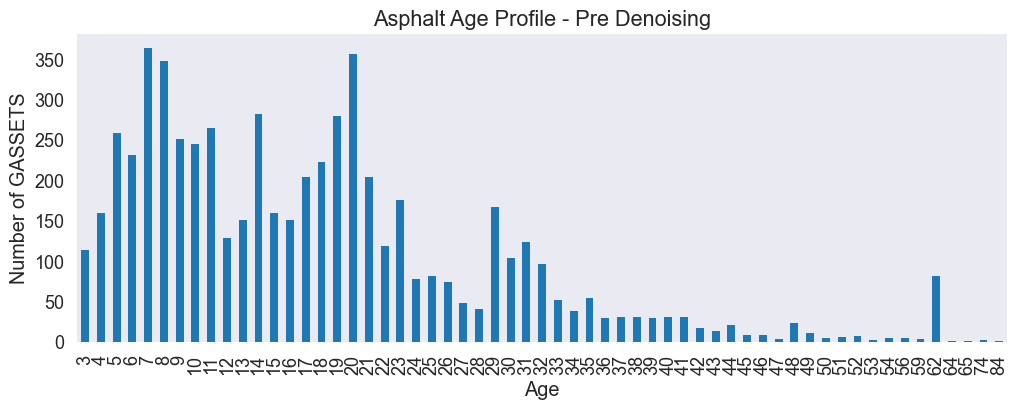

{1: 24, 2: 20, 3: 20, 4: 19, 5: 17, 6: 18, 7: 19, 8: 19, 9: 19, 10: 13}


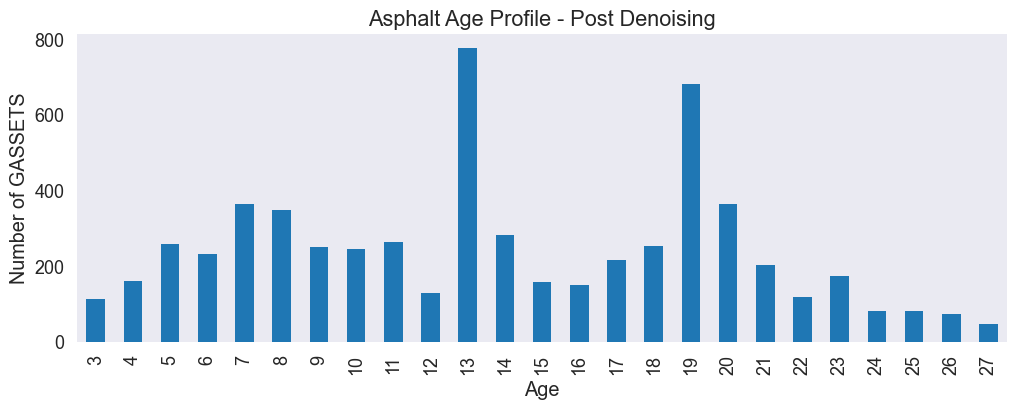

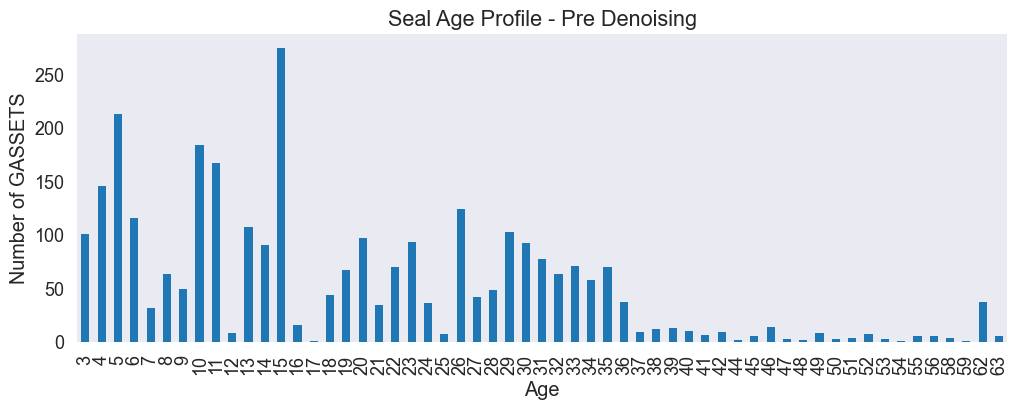

{1: 20, 2: 20, 3: 26, 4: 20, 5: 22, 6: 21, 7: 19, 8: 18, 9: 16, 10: 12}


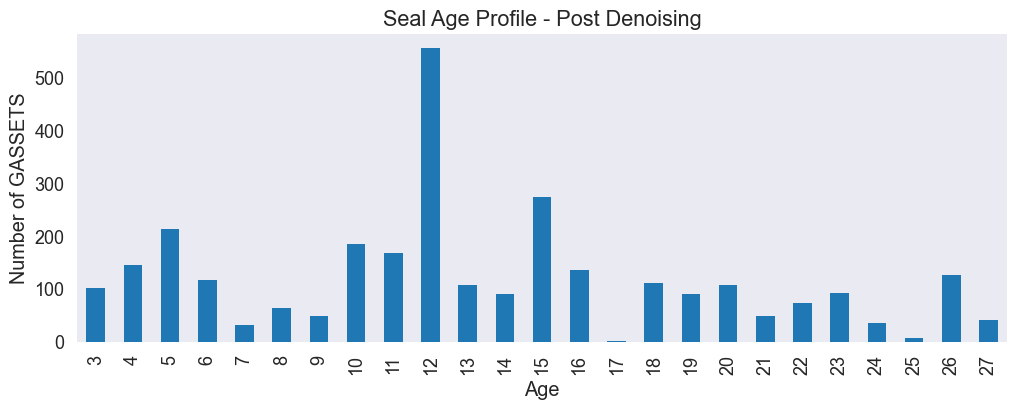

In [11]:
# %%

""" Plot Age """
age_profile(asphalt, 'Asphalt',27)
age_profile(seal, 'Seal', 27)

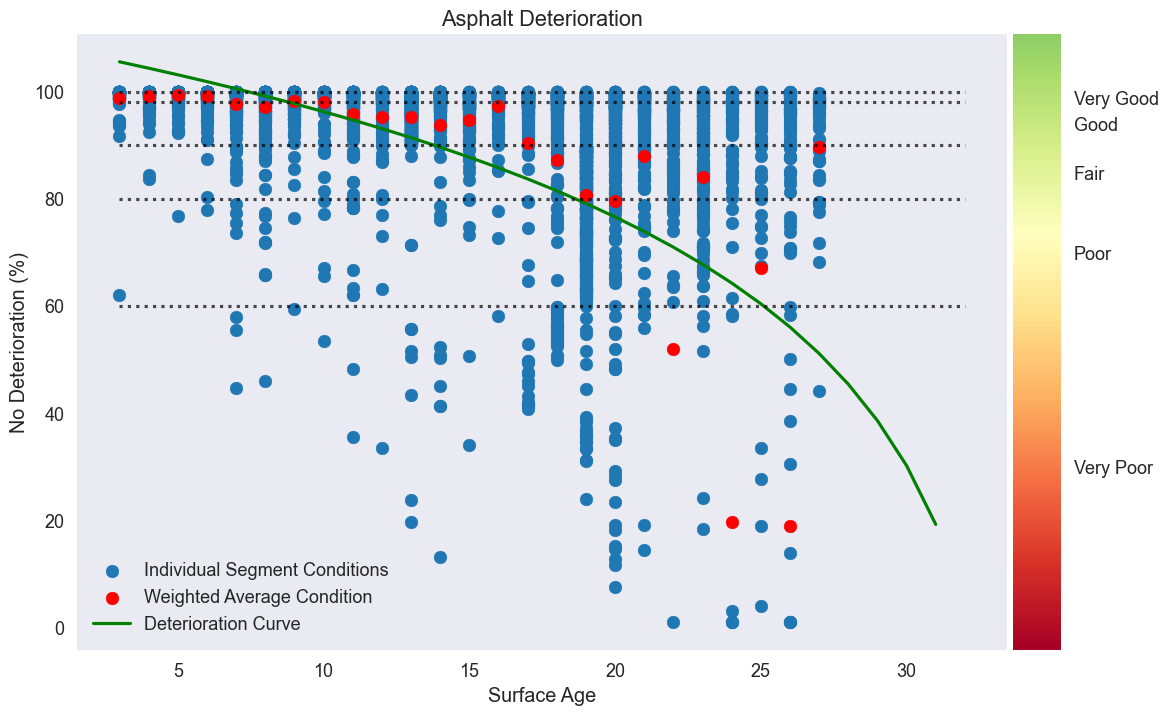

No Deterioration = 36.106843722802374 * ln(-(surface age - 33.81621104908347)) + -18.200857054246782
Regression Coefficients: [ 36.10684372  33.81621105 -18.20085705]
Spearmans Rank Correlation Coefficient is 0.9207692307692308



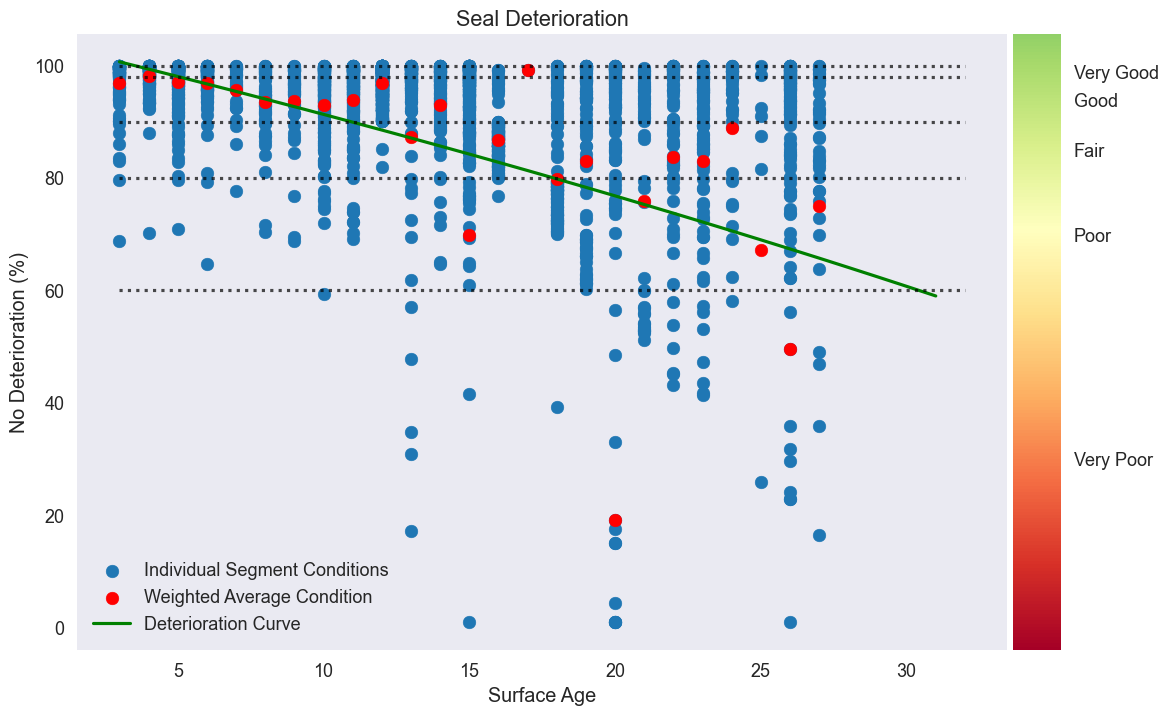

No Deterioration = 146.0188805895314 * ln(-(surface age - 115.76645732385448)) + -589.3110602717106
Regression Coefficients: [ 146.01888059  115.76645732 -589.31106027]
Spearmans Rank Correlation Coefficient is 0.7815384615384615



In [12]:
# %%

""" Condition Visualisation and Curve Fitting """
import statistics
import scipy.optimize as optimize
from scipy.stats import spearmanr

def degradation(x, a, b, c):
    # logarithmic function
    return a*(np.log(-(x-b)))+c

def plot_curves(data:gpd.GeoDataFrame, title:str, guess:list):

    thresholds = [100,98,90,80,60]
    buffer = 5

    ages = list(data['AGE'].unique())
    ages.sort()

    hmeans = []
    ameans=[]

    for age in ages:
        ypoint = statistics.harmonic_mean(list(data[data['AGE']==age]['REMAINING_LIFE(%)']))
        hmeans.append(ypoint)
        ypoint2 = data[data['AGE']==age]['REMAINING_LIFE(%)'].mean()
        ameans.append(ypoint2)
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.scatter(data['AGE'], data['REMAINING_LIFE(%)'], label = 'Individual Segment Conditions')
    #ax.scatter(ages, ameans, color='orange')
    ax.scatter(ages, hmeans, color='red', label = "Weighted Average Condition")
    popt, pcov = optimize.curve_fit(degradation, ages, hmeans, p0=guess, method='lm')
    ax.plot(range(min(ages),max(ages)+buffer), degradation(range(min(ages),max(ages)+buffer), *popt), 'g-', label='Deterioration Curve')
    ax.hlines(thresholds,min(ages),max(ages)+buffer, color='k',linestyle='dotted',alpha=0.7)

    cax = fig.add_axes([ax.get_position().x1 + 0.005,ax.get_position().y0,0.04,ax.get_position().height])
    sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=ax.get_ylim()[0], vmax=ax.get_ylim()[1]+40))
    sm._A = []
    cbar = plt.colorbar(sm, cax=cax, ticks=[30, 70, 85, 94, 99])
    cbar.ax.set_yticklabels(['Very Poor', 'Poor', 'Fair', 'Good', 'Very Good'])
    #cbar.ax.set_yticklabels([5,4,3,2,1])
    cbar.ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
    #cbar.ax.set_title('Condition')
    ax.legend(loc='lower left')
    ax.set_xlabel('Surface Age')
    ax.set_ylabel('No Deterioration (%)')
    ax.set_title(title)
    plt.show()

    correlation = spearmanr(hmeans, degradation(range(min(ages),max(ages)+1), *popt)).correlation
    print(f'No Deterioration = {popt[0]} * ln(-(surface age - {popt[1]})) + {popt[2]}')
    print(f'Regression Coefficients: {popt}')
    print(f'Spearmans Rank Correlation Coefficient is {correlation}\n')

plot_curves(asphalt, 'Asphalt Deterioration', [30,30,28.6])
plot_curves(seal, 'Seal Deterioration', [30,30,28.6])